# Covid-19 Data Analysis

## Data Source

Source data for this notebook may be found on [GitHub](https://github.com/) at
[covid-19](https://github.com/datasets/covid-19.git).  Additional data may
be found from the [NY Times](https://github.com/nytimes/covid-19-data.git).

In [1]:
%%bash
if [ ! -d covid-19 ]; then
    git clone https://github.com/datasets/covid-19.git
    (cd covid-19; git config pull.rebase false)
else
    (cd covid-19; git pull)
fi

(cd covid-19; git log -n 1)

From https://github.com/datasets/covid-19
   200f402..1ca4bab  main       -> origin/main
Updating 200f402..1ca4bab
Fast-forward
 data/countries-aggregated.csv          |  2160 ++-
 data/key-countries-pivoted.csv         |     8 +-
 data/time-series-19-covid-combined.csv |  2664 ++-
 data/us_confirmed.csv                  | 20072 ++++++++++++++++++++++-
 data/us_deaths.csv                     | 27124 ++++++++++++++++++++++++++----
 data/us_simplified.csv                 | 27144 +++++++++++++++++++++++++++----
 data/worldwide-aggregate.csv           |   990 +-
 7 files changed, 71587 insertions(+), 8575 deletions(-)
commit 1ca4bab06d29b241625c004da5a3b51ed920dafd
Author: GitHub Action <action@github.com>
Date:   Wed Aug 18 06:13:34 2021 +0000

    Auto-update of the data packages


In [2]:
%%bash
ls covid-19/data

countries-aggregated.csv
key-countries-pivoted.csv
reference.csv
time-series-19-covid-combined.csv
us_confirmed.csv
us_deaths.csv
us_simplified.csv
worldwide-aggregate.csv


# Dependencies

In [3]:
%%pom
---
dependencies:
- org.knowm.xchart:xchart:3.8.0

## Spark

In [4]:
%%spark-session local[*] covid-19

local[*]

In [5]:
import org.apache.spark.*;
import org.apache.spark.sql.*;
import org.apache.spark.sql.types.*;

import static org.apache.spark.sql.functions.*;

var session = SparkSession.active();
var reader = session.read().option("header", true).option("inferSchema", true);

var countries_aggregated =
    reader.csv("covid-19/data/countries-aggregated.csv")
    .withColumn("Date", col("Date").cast(DataTypes.DateType));
var key_countries_pivoted =
    reader.csv("covid-19/data/key-countries-pivoted.csv")
    .withColumn("Date", col("Date").cast(DataTypes.DateType));
var reference = reader.csv("covid-19/data/reference.csv");
var time_series_19_covid_combined =
    reader.csv("covid-19/data/time-series-19-covid-combined.csv")
    .withColumn("Date", col("Date").cast(DataTypes.DateType));
var us_confirmed =
    reader.csv("covid-19/data/us_confirmed.csv")
    .withColumn("Date", col("Date").cast(DataTypes.DateType));
var us_deaths =
    reader.csv("covid-19/data/us_deaths.csv")
    .withColumn("Date", col("Date").cast(DataTypes.DateType));
var us_simplified =
    reader.csv("covid-19/data/us_simplified.csv")
    .withColumn("Date", col("Date").cast(DataTypes.DateType));
var worldwide_aggregate =
    reader.csv("covid-19/data/worldwide-aggregate.csv")
    .withColumn("Date", col("Date").cast(DataTypes.DateType));

In [6]:
us_simplified.printSchema();

root
 |-- Date: date (nullable = true)
 |-- Admin2: string (nullable = true)
 |-- Province/State: string (nullable = true)
 |-- Confirmed: integer (nullable = true)
 |-- Deaths: integer (nullable = true)
 |-- Country/Region: string (nullable = true)



In [7]:
us_simplified.show(40);

+----------+-------+--------------+---------+------+--------------+
|      Date| Admin2|Province/State|Confirmed|Deaths|Country/Region|
+----------+-------+--------------+---------+------+--------------+
|2020-01-22|Autauga|       Alabama|        0|     0|            US|
|2020-01-23|Autauga|       Alabama|        0|     0|            US|
|2020-01-24|Autauga|       Alabama|        0|     0|            US|
|2020-01-25|Autauga|       Alabama|        0|     0|            US|
|2020-01-26|Autauga|       Alabama|        0|     0|            US|
|2020-01-27|Autauga|       Alabama|        0|     0|            US|
|2020-01-28|Autauga|       Alabama|        0|     0|            US|
|2020-01-29|Autauga|       Alabama|        0|     0|            US|
|2020-01-30|Autauga|       Alabama|        0|     0|            US|
|2020-01-31|Autauga|       Alabama|        0|     0|            US|
|2020-02-01|Autauga|       Alabama|        0|     0|            US|
|2020-02-02|Autauga|       Alabama|        0|   

In [8]:
import java.util.Map;

var by_state =
    us_simplified
    .groupBy("Country/Region", "Province/State")
    .agg(Map.of("Deaths", "max"))
    .orderBy("max(Deaths)");

In [9]:
by_state.show(100);

+--------------+--------------------+-----------+
|Country/Region|      Province/State|max(Deaths)|
+--------------+--------------------+-----------+
|            US|    Diamond Princess|          0|
|            US|      American Samoa|          0|
|            US|Northern Mariana ...|          2|
|            US|      Grand Princess|          3|
|            US|      Virgin Islands|         41|
|            US|             Vermont|        108|
|            US|             Wyoming|        144|
|            US|                Guam|        144|
|            US|              Alaska|        200|
|            US|               Maine|        206|
|            US|        North Dakota|        215|
|            US|             Montana|        286|
|            US|        South Dakota|        366|
|            US|       West Virginia|        367|
|            US|              Hawaii|        426|
|            US|         Mississippi|        489|
|            US|               Idaho|        497|


In [10]:
var dates = time_series_19_covid_combined.select("Date").distinct().orderBy("Date");
var interval = dates.agg(min("Date"), max("Date")).head();
var snapshot =
    time_series_19_covid_combined
    .filter(col("Date").leq(interval.get(1)))
    .groupBy(col("Country/Region"))
    .agg(max(col("Deaths")).as("Deaths"))
    .orderBy(desc("Deaths"));

print(snapshot);

,Country/Region,Deaths
0,US,623321
1,Brazil,570598
2,India,432079
3,Mexico,249529
4,Peru,197539
5,Russia,169169
6,United Kingdom,131149
7,Italy,128510
8,Colombia,123688
9,Indonesia,120013


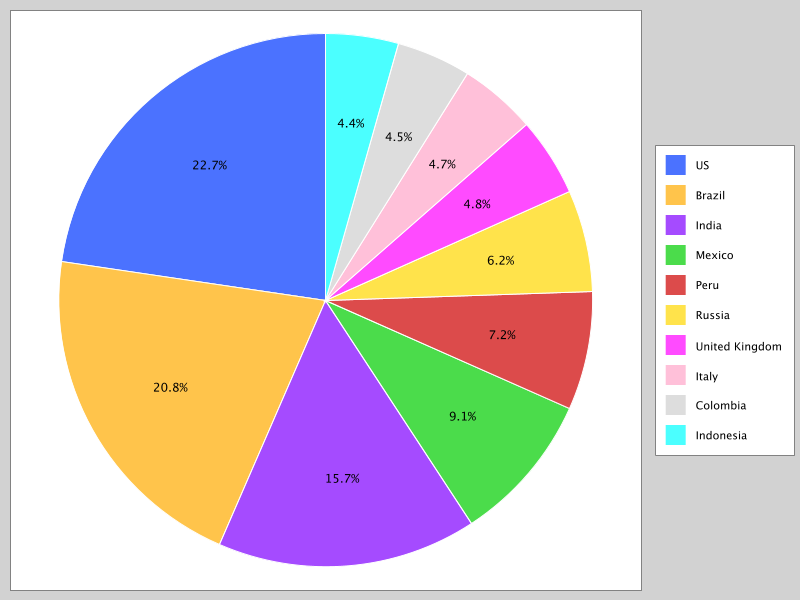

In [11]:
import org.knowm.xchart.*;

var chart = new PieChartBuilder().width(800).height(600).build();

snapshot.collectAsList().stream().limit(10).forEach(r -> chart.addSeries(r.getAs(0), r.getAs(1)));

print(chart);